In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_group: "03_10_24_RandomCircles_TS_vs_LTS_wAugmentation"
    
calibration:
    metric_cfg_file: "/storage/vbutoi/projects/ESE/ese/experiment/configs/inference/Calibration_Metrics.yaml"

options:
    add_baseline_rows: True 
    load_pixel_meters: False 
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    load_groupavg_metrics: False
    remove_shared_columns: False
    equal_rows_per_cfg_assert: True 

<IPython.core.display.Javascript object>

In [3]:
from ese.experiment.analysis.analyze_inf import load_cal_inference_stats

image_info_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False
)

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 23328 -> 23328 rows.
Finished loading inference stats.
Log amounts: log.root                                                                                                             log_set                                              
/storage/vbutoi/scratch/ESE/inference/03_10_24_RandomCircles_TS_vs_LTS_wAugmentation/Shapes_Ensemble_LTS             20240310_221417-MLF6-637d01687eef93253a65edad3c007db6    1377
                                                                                                                     20240310_221420-F8A9-cfb1f1239547d4d7620d4639e1eb7af0    1377
/storage/vbutoi/scratch/ESE/inference/03_10_24_RandomCircles_TS_vs_LTS_wAugmentation/Shapes_Ensemble_TempScaling     20240310_221358-MHF6-8c315c0409df83c520e16e9765dee520    1377
                                                                                                                     20240310_221402-4J1F-73071b473352cfc

In [4]:
image_info_df['calibrator'].unique()

array(['TempScaling', 'Uncalibrated', 'LTS'], dtype=object)

In [5]:
image_info_df.keys()

Index(['data_id', 'split', 'slice_idx', 'image_metric', 'metric_score',
       'num_lab_0_pixels', 'num_lab_1_pixels', 'ECE', 'Edge-ECE', 'CW-ECE',
       'ECW-ECE', 'Uniform-CW-ECE', 'Uniform-ECW-ECE', 'ELM', 'Edge-ELM',
       'Uniform-ELM', 'Uniform-Edge-ELM', 'log_set', 'data.preload',
       'data.splits', 'data.subsplit', 'dataloader.batch_size',
       'dataloader.num_workers', 'dataloader.pin_memory', 'dataset._class',
       'dataset.binarize', 'dataset.preload', 'dataset.return_data_id',
       'dataset.subsplit', 'dataset.version', 'ensemble.combine_fn',
       'ensemble.combine_quantity', 'ensemble.member_w_metric',
       'ensemble.normalize', 'experiment.dataset_name', 'experiment.exp_root',
       'experiment.pretrained_seed', 'experiment.seed',
       'global_calibration.neighborhood_width',
       'global_calibration.num_classes', 'global_calibration.num_prob_bins',
       'global_calibration.square_diff',
       'local_calibration.neighborhood_width',
       'local_ca

## We are going to remove the case where there are very few pixels, cause unrealistic outliers.

In [6]:
# Sort the image_info_df by method name, so everything appears nicely
image_info_df = image_info_df.sort_values(by=['method_name', 'calibrator'])
# Make sure that the model_class 'Uncalibrated' is first
image_info_df['calibrator'] = image_info_df['calibrator'].astype('category')
image_info_df['calibrator'] = image_info_df['calibrator'].cat.reorder_categories([
    'Uncalibrated',
    'TempScaling', 
    'LTS'
])

In [7]:
image_info_df['method_name'].unique()

array(['Average UNet', 'Ensemble (mean, probs)',
       'Ensemble (product, probs)', 'UNet (seed=40)', 'UNet (seed=41)',
       'UNet (seed=42)', 'UNet (seed=43)'], dtype=object)

In [8]:
# Select only the rows corresponding to group methods
image_info_df = image_info_df[image_info_df['model_type'] == 'group']

image_info_df['method_name'] = image_info_df['method_name'].astype('category')
image_info_df['method_name'] = image_info_df['method_name'].cat.reorder_categories([
    'Average UNet',
    'Ensemble (mean, probs)', 
    'Ensemble (product, probs)', 
    # 'UNet (seed=40)', 
    # 'UNet (seed=41)', 
    # 'UNet (seed=42)', 
    # 'UNet (seed=43)', 
])

image_info_df['split'] = image_info_df['split'].astype('category')
image_info_df['split'] = image_info_df['split'].cat.reorder_categories([
    'val',
    'cal'
])

# Let's looks at the calibration scores of our models.

## ECE Metrics

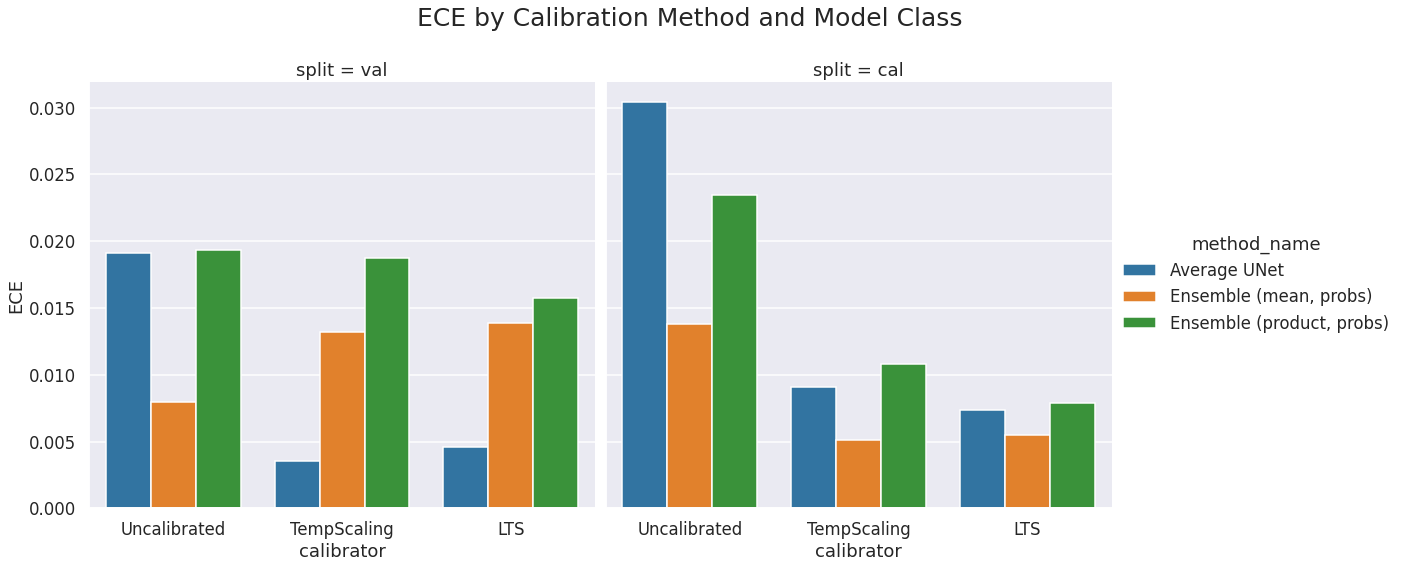

In [9]:
g = sns.catplot(
    data=image_info_df,
    x="calibrator",
    y="ECE",
    hue="method_name",
    col="split",
    kind="bar",
    height=8,
    # aspect=3,
    sharex=False
)
g.fig.suptitle("ECE by Calibration Method and Model Class", fontsize=25)
g.fig.subplots_adjust(top=0.85)

In [10]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="CW-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.001))
# g.fig.suptitle("CW-ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [11]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Uniform-CW-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.001))
# g.fig.suptitle("Uniform-CW-ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [12]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Edge-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.05))
# g.fig.suptitle("Edge ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [13]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="ECW-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.004))
# g.fig.suptitle("Edge CW-ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [14]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Uniform-ECW-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.05))
# g.fig.suptitle("Uniform ECW-ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

## ELM Metrics

In [15]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="ELM",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.001))
# g.fig.suptitle("ELM by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [16]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Edge-ELM",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.001))
# g.fig.suptitle("Edge-ELM by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [17]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Uniform-ELM",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.3))
# g.fig.suptitle("Uniform-ELM by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [18]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Uniform-Edge-ELM",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.3))
# g.fig.suptitle("Uniform-Edge-ELM by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

## Now we can look at the quality averages themselves, first looking slice-wise.

In [19]:
image_info_df["image_metric"].unique()

array(['BoundaryIOU', 'Dice', 'HD95', 'Hard-Region-Ambiguity',
       'Image_CW-ECE', 'Image_ECE', 'Image_ECW-ECE', 'Image_ELM',
       'Image_Edge-ECE', 'Image_Edge-ELM', 'Image_Uniform-CW-ECE',
       'Image_Uniform-ECW-ECE', 'Image_Uniform-ELM',
       'Image_Uniform-Edge-ELM', 'Pixel-Ambiguity',
       'Soft-Region-Ambiguity', 'Dice Loss'], dtype=object)

In [20]:
# Load the pickled df corresponding to the upper-bound of the uncalibrated UNets
from ese.experiment.analysis.analysis_utils.inference_utils import load_upperbound_df 

# Fill the column corresponding to slice_idx with string 'None'
upperbound_df = load_upperbound_df(results_cfg['log'])

Error loading upperbound df: [Errno 2] No such file or directory: '/storage/vbutoi/scratch/ESE/inference/03_10_24_RandomCircles_TS_vs_LTS_wAugmentation/ensemble_upper_bounds/'


In [21]:
upperbound_df

In [22]:
from ese.experiment.analysis.analysis_utils.plot_utils import plot_upperbound_line

num_calibrators = len(image_info_df['calibrator'].unique())

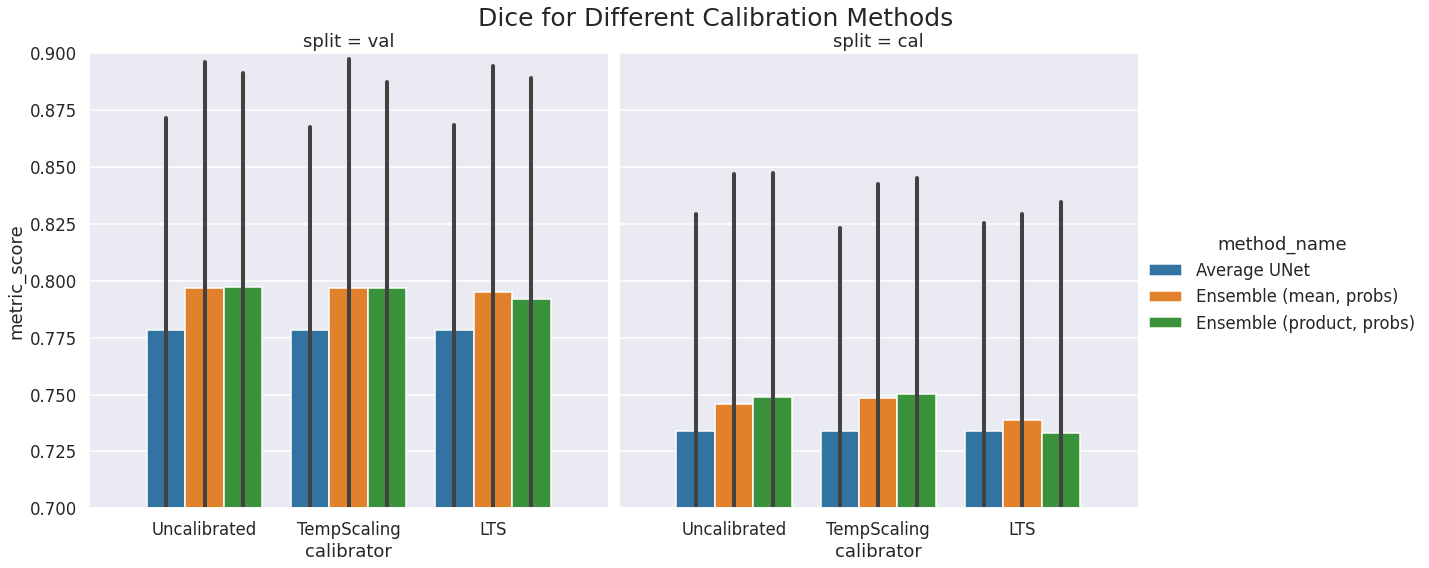

In [23]:
g = sns.catplot(
    data=image_info_df[image_info_df["image_metric"] == "Dice"],
    x="calibrator",
    y="metric_score",
    hue="method_name",
    col="split",
    kind="bar",
    height=8,
    # aspect=3,
    sharex=False
)
if upperbound_df is not None:
    plot_upperbound_line(
        graph=g, 
        plot_df=dice_ub_df, 
        y="metric_score", 
        num_calibrators=num_calibrators, 
        col="split"
    )
# Set the title of the bar plot
g.fig.suptitle("Dice for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.90)
# Set the y axis to be between 0.5 and 1.0
calibrators_width = num_calibrators - 1
g.set(xlim=(-0.8, calibrators_width + 0.8))
g.set(ylim=(0.70, 0.90))

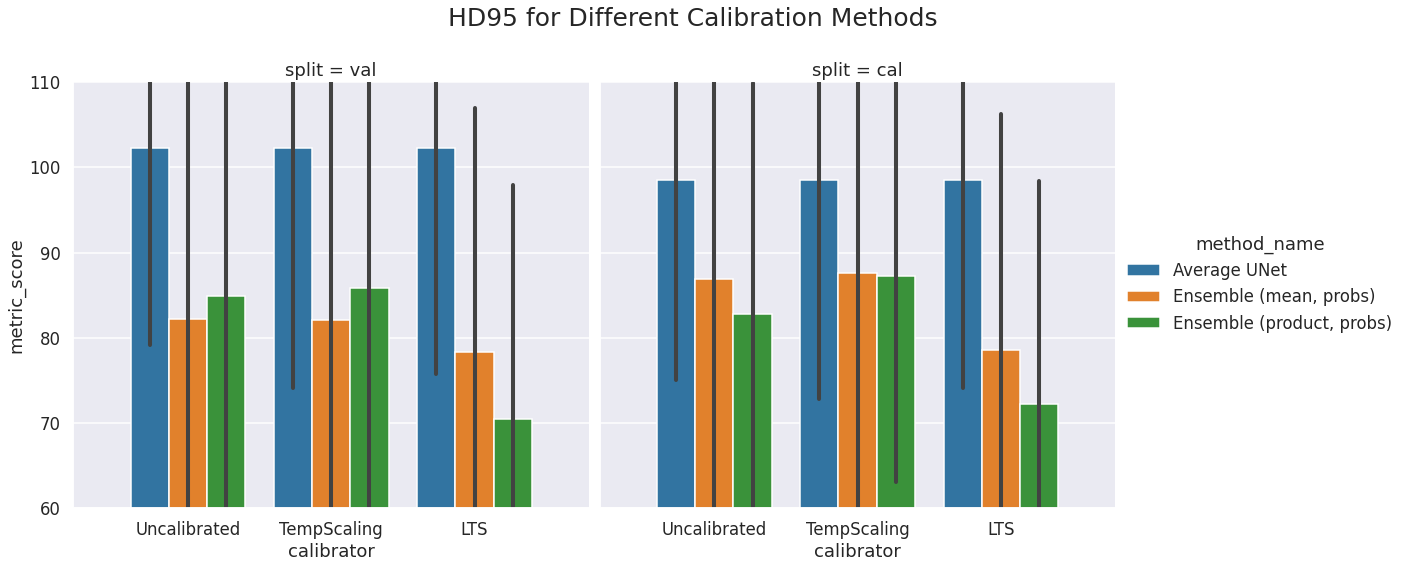

In [24]:
g = sns.catplot(
    data=image_info_df[image_info_df["image_metric"] == "HD95"],
    x="calibrator",
    y="metric_score",
    hue="method_name",
    col="split",
    kind="bar",
    height=8,
    # aspect=3
)
if upperbound_df is not None:
    plot_upperbound_line(
        graph=g, 
        plot_df=hd95_ub_df, 
        y="metric_score", 
        num_calibrators=num_calibrators, 
        col="split"
    )
# Set the title of the bar plot
g.fig.suptitle("HD95 for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.85)
# Set the y axis to be between 0.5 and 1.0
calibrators_width = num_calibrators - 1
g.set(xlim=(-0.8, calibrators_width + 0.8))
g.set(ylim=(60.0, 110.0))

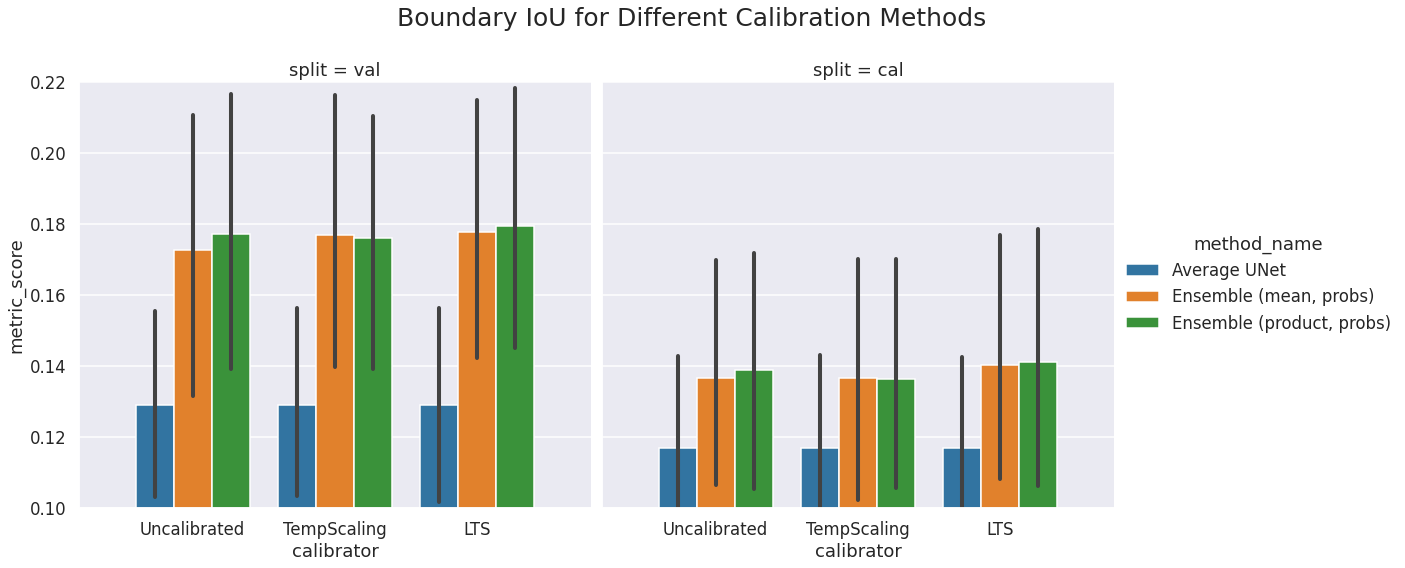

In [25]:
g = sns.catplot(
    data=image_info_df[image_info_df["image_metric"] == "BoundaryIOU"],
    x="calibrator",
    y="metric_score",
    hue="method_name",
    col="split",
    kind="bar",
    height=8,
    sharex=False
)
if upperbound_df is not None:
    plot_upperbound_line(
        graph=g, 
        plot_df=boundaryiou_df, 
        y="metric_score", 
        num_calibrators=num_calibrators, 
        col="split"
    )
# Set the title of the bar plot
g.fig.suptitle("Boundary IoU for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.85)
# Set the y axis to be between 0.5 and 1.0
calibrators_width = num_calibrators - 1
g.set(xlim=(-0.8, calibrators_width + 0.8))
g.set(ylim=(0.10, 0.22))

## Perf Per Size

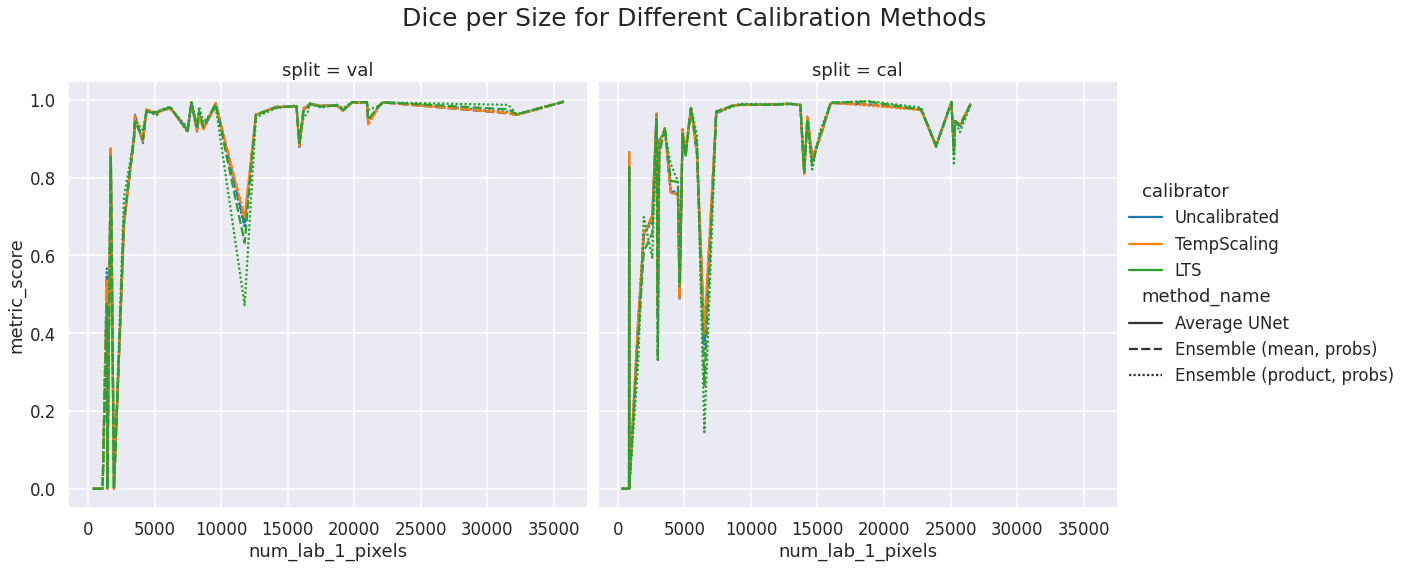

In [26]:
g = sns.relplot(
    data=image_info_df[image_info_df["image_metric"] == "Dice"],
    x="num_lab_1_pixels",
    y="metric_score",
    hue="calibrator",
    style="method_name",
    col="split",
    kind="line",
    height=8,
)
# Set the title of the bar plot
g.fig.suptitle("Dice per Size for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.85)
# Set the y axis to be between 0.5 and 1.0

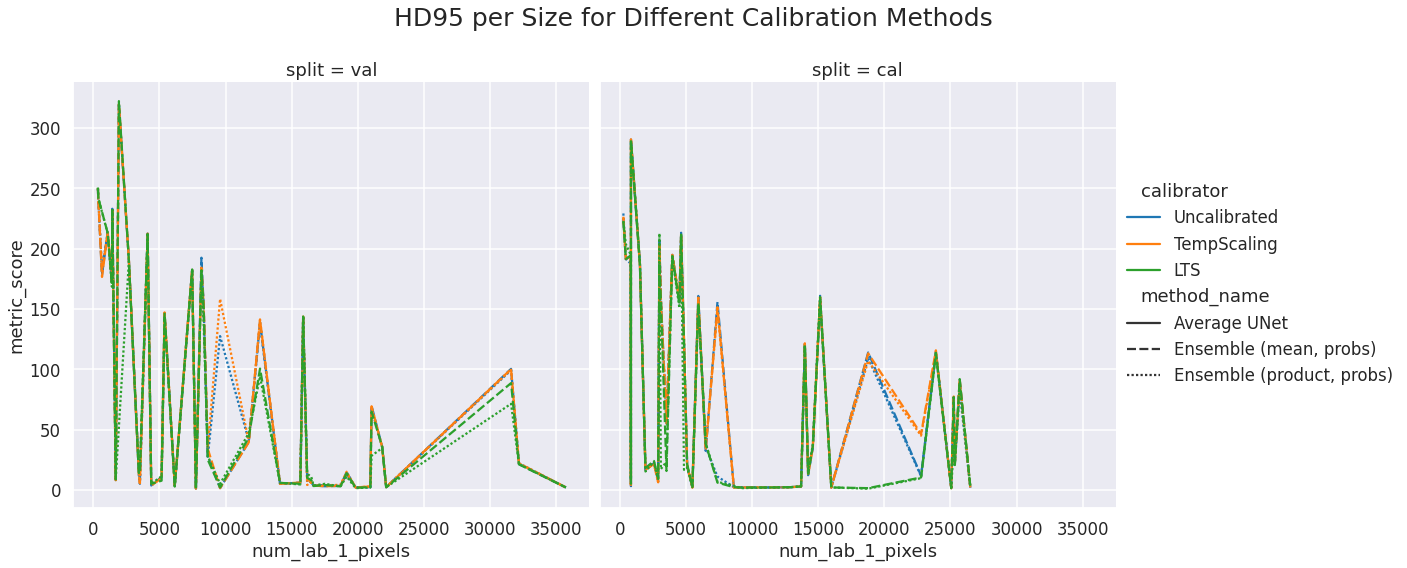

In [27]:
g = sns.relplot(
    data=image_info_df[image_info_df["image_metric"] == "HD95"],
    x="num_lab_1_pixels",
    y="metric_score",
    hue="calibrator",
    style="method_name",
    col="split",
    kind="line",
    height=8,
)
# Set the title of the bar plot
g.fig.suptitle("HD95 per Size for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.85)
# Set the y axis to be between 0.5 and 1.0

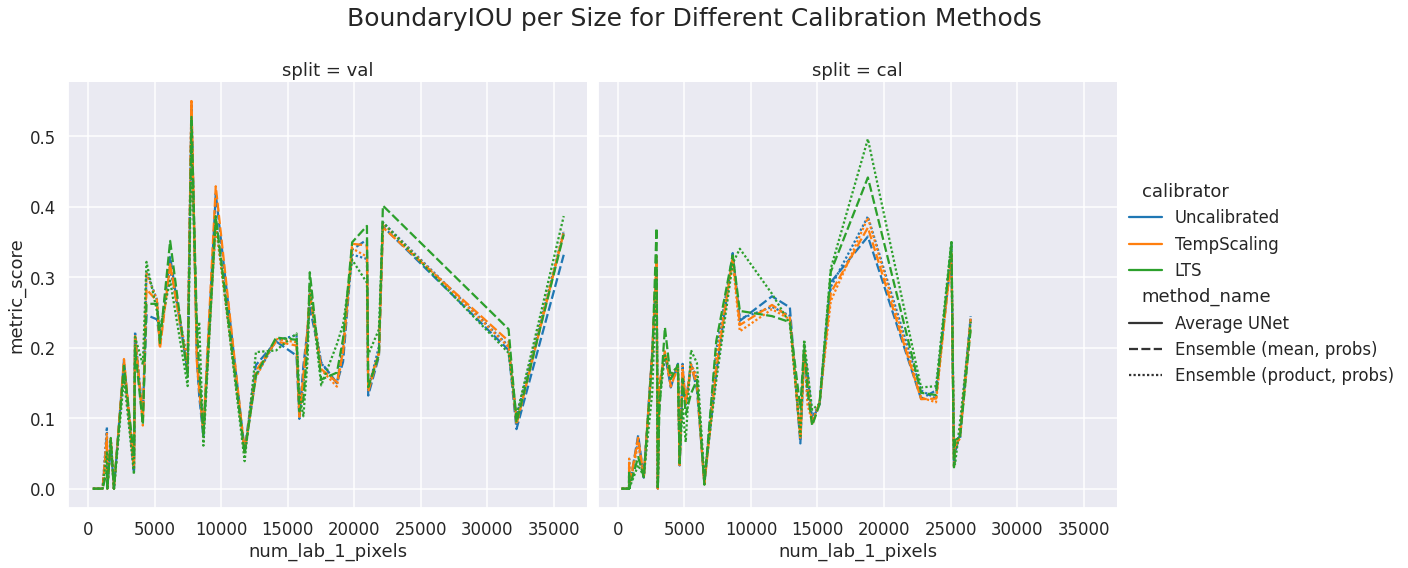

In [28]:
g = sns.relplot(
    data=image_info_df[image_info_df["image_metric"] == "BoundaryIOU"],
    x="num_lab_1_pixels",
    y="metric_score",
    hue="calibrator",
    style="method_name",
    col="split",
    kind="line",
    height=8,
)
# Set the title of the bar plot
g.fig.suptitle("BoundaryIOU per Size for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.85)
# Set the y axis to be between 0.5 and 1.0

# Looking at Ensemble Variance Under Different Definitions

In [29]:
ensemble_info_df = image_info_df[image_info_df['method_name'] != "Average UNet"]

In [30]:
# g = sns.catplot(
#     data=ensemble_info_df[ensemble_info_df["image_metric"] == "Avg-PW Soft-Dice"],
#     x="calibrator",
#     y="metric_score",
#     col="split",
#     kind="bar",
#     height=8,
#     aspect=3,
# )
# # Set the title of the bar plot
# g.fig.suptitle("Average Pairwise Soft Dice for Different Calibration Methods", fontsize=25)
# # Give the title a bit of spacing from the plot
# g.fig.subplots_adjust(top=0.85)
# # Set the y axis to be between 0.5 and 1.0
# calibrators_width = num_calibrators - 1
# g.set(xlim=(-0.8, calibrators_width + 0.8))
# # g.set(ylim=(0.8, 1.0))

In [31]:
# g = sns.catplot(
#     data=ensemble_info_df[ensemble_info_df["image_metric"] == "Avg-PW Hard-Dice"],
#     x="calibrator",
#     y="metric_score",
#     col="split",
#     kind="bar",
#     height=8,
#     aspect=3,
# )
# # Set the title of the bar plot
# g.fig.suptitle("Average Pairwise Hard Dice for Different Calibration Methods", fontsize=25)
# # Give the title a bit of spacing from the plot
# g.fig.subplots_adjust(top=0.85)
# # Set the y axis to be between 0.5 and 1.0
# calibrators_width = num_calibrators - 1
# g.set(xlim=(-0.8, calibrators_width + 0.8))
# # g.set(ylim=(0.8, 1.0))

In [32]:
# g = sns.catplot(
#     data=ensemble_info_df[ensemble_info_df["image_metric"] == "Ensemble-VAR"],
#     x="calibrator",
#     y="metric_score",
#     col="split",
#     kind="bar",
#     height=8,
#     aspect=3,
# )
# # Set the title of the bar plot
# g.fig.suptitle("Ensemble Variance Pixel-Probs for Different Calibration Methods", fontsize=25)
# # Give the title a bit of spacing from the plot
# g.fig.subplots_adjust(top=0.85)
# # Set the y axis to be between 0.5 and 1.0
# calibrators_width = num_calibrators - 1
# g.set(xlim=(-0.8, calibrators_width + 0.8))
# # g.set(ylim=(0.8, 1.0))

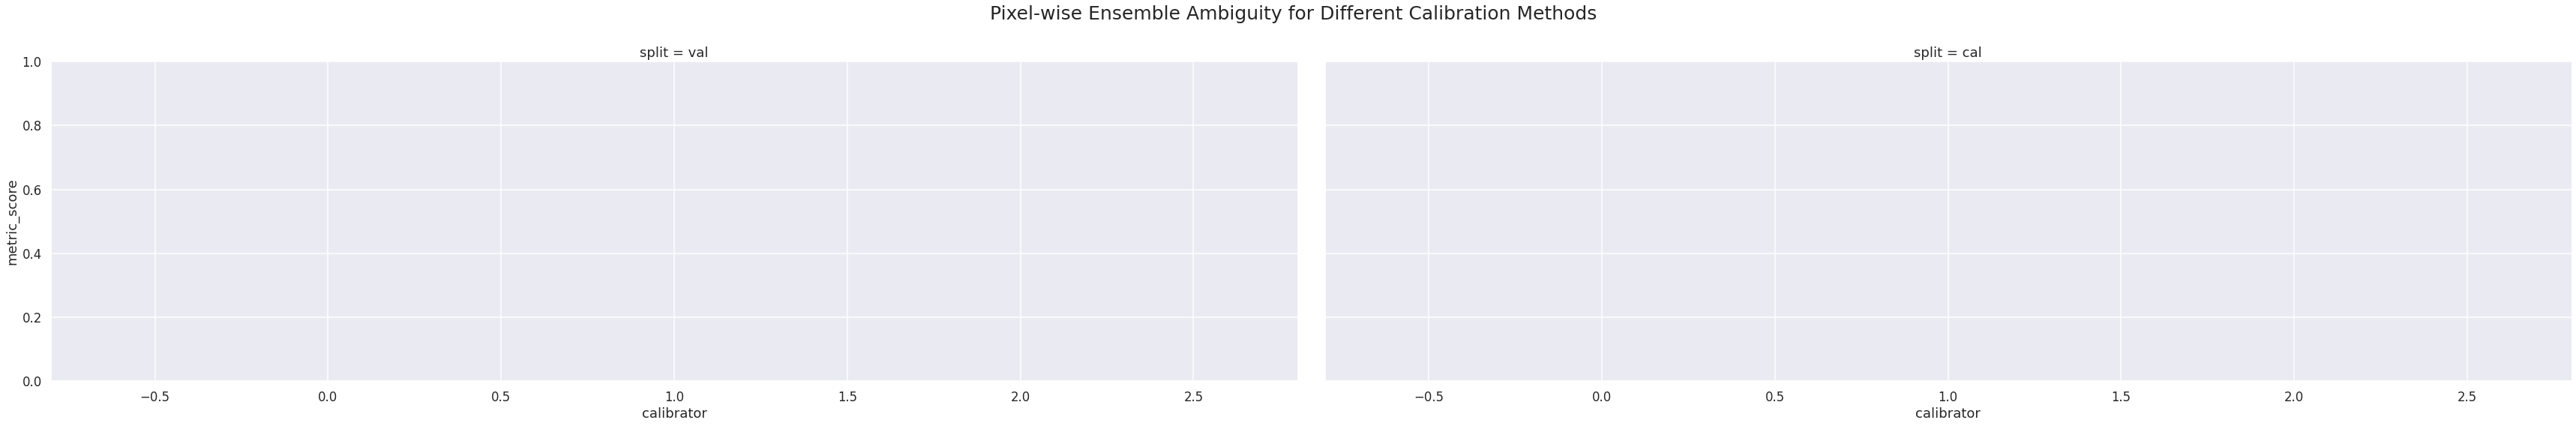

In [33]:
g = sns.catplot(
    data=ensemble_info_df[ensemble_info_df["image_metric"] == "Ambiguity"],
    x="calibrator",
    y="metric_score",
    col="split",
    kind="bar",
    height=8,
    aspect=3,
)
# Set the title of the bar plot
g.fig.suptitle("Pixel-wise Ensemble Ambiguity for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.85)
# Set the y axis to be between 0.5 and 1.0
calibrators_width = num_calibrators - 1
g.set(xlim=(-0.8, calibrators_width + 0.8))
# g.set(ylim=(0.0, 0.015))